# Analyzing Data with Pandas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
%matplotlib inline

## Data Types

### Finding the right data types
Data can be expressed in several levels of measurement. You need to make sure to find the level of measurement that both semantically and computationally makes sense.

A quick detour to scales of measurement
1. **Nominal level** <br/>
   Numbers only represent categories and nothing more. <br/>
   E.g.: genders, colors<br/>
   You can compute: absolute and relative frequencies, mode   
   
1. **Ordinal level** <br/>
   The order has a meaning.<br/>
   E.g.: school-grades, music charts, answers on a likert scale <br/>
   You can additionally compute: cumulative frequencies, median, quantiles   
   
1. **Interval level** <br/>
   Same intervals should convey same meaning.<br/>
   E.g.: temperature in celsius, (intelligence) tests<br/>
   You can additionally compute: mean, standard deviation   

1. **Ratio level**<br/>
   Ratios convey meaning and there is a specific 0 point.<br/>
   E.g.: mass, size, time, speed<br/>
   You can compute: coefficient of variation $c = \frac{s}{\bar X}$, i.e. a normalized standard variation 

### Categorical data
https://pandas.pydata.org/pandas-docs/stable/categorical.html

Using a categorical dtype has several advantages

* it keeps memory usage low
* it makes data useable for numeric modeling algorithms
* it signals to libraries that build on pandas how to treat the data
* it makes the intent clear, that only certain values are allowed in a column and how they relate to each other

The following `Series` could be perfectly represented using categories instead of strings.

In [3]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'])
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: object

In [4]:
print(f'The string series is {s.nbytes} bytes big.')

The string series is 48 bytes big.


By specifying the `dtype` as "category" the data is automatically converted to a categorical scale.

In [5]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'], dtype='category')
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: category
Categories (3, object): ['a', 'b', 'c']

In fact the `Series` gets much smaller already. The effect will be stronger on larger `Series` (and converge to a certain compression rate for infinitely large series).

In [6]:
print(f'The categorical series is {s.nbytes} bytes big.')

The categorical series is 30 bytes big.


Categorical data is stored using numeric codes under the hood that map to categories.

In [7]:
s.cat.categories

Index(['a', 'b', 'c'], dtype='object')

In [8]:
s.cat.codes

0    0
1    1
2    1
3    0
4    2
5    2
dtype: int8

The `.cat` accessor allows changing, renaming and ordering categories.

In [9]:
s.cat.categories

Index(['a', 'b', 'c'], dtype='object')

In [10]:
s.cat.rename_categories(['x', 'y', 'z'])

0    x
1    y
2    y
3    x
4    z
5    z
dtype: category
Categories (3, object): ['x', 'y', 'z']

Using `dtype='category'` will create unordered categories by default.

In [11]:
s.cat.ordered

False

A categorical series can also be created from `pd.Categorical`. This allows you set the categories and the ordering explicitly.

In [14]:
pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c'], 
                     ordered=False)

[NaN, 'b', 'c', NaN]
Categories (2, object): ['b', 'c']

The `Categorical` object can then be passed to the `Series` constructor to obtain a real `Series`.

In [15]:
cat_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

### Ordered Categories
What does it mean to have ordered categories?

In [16]:
cat_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series2

0    c
1    a
2    c
3    b
dtype: category
Categories (3, object): ['b', 'c', 'a']

In [17]:
cat_series == cat_series2

0    False
1    False
2     True
3    False
dtype: bool

In [18]:
cat_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

In [19]:
cat_series.mode()

0    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

These semantics are lost when you pull out the atomic values. Only the `Series` is categorical, not the single entries.

In [20]:
cat_series.iloc[0], type(cat_series.iloc[0])

('a', str)

In [21]:
cat_series.iloc[0] < cat_series.iloc[1]

True

Now the same for an **ordered** cateogorical `Series`.

In [22]:
cat_ordered_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a', 'c'], categories=['b', 'c', 'a', 'd'],
                         ordered=True)
)
cat_ordered_series

0    a
1    b
2    c
3    a
4    c
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [23]:
cat_ordered_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b', 'c'], categories=['b', 'c', 'a', 'd'],
                    ordered=True)
)
cat_ordered_series2

0    c
1    a
2    c
3    b
4    c
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [24]:
cat_ordered_series == cat_ordered_series2

0    False
1    False
2     True
3    False
4     True
dtype: bool

In [25]:
cat_ordered_series > cat_ordered_series2

0     True
1    False
2    False
3     True
4    False
dtype: bool

In [26]:
cat_ordered_series.max()

'a'

The median does not work on the categorical Series but can be computed using the codes.

In [27]:
cat_ordered_series

0    a
1    b
2    c
3    a
4    c
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [28]:
print(cat_ordered_series.cat.categories)
cat_ordered_series.cat.codes.median()

Index(['b', 'c', 'a', 'd'], dtype='object')


1.0

If you need to cast existing data, to a categorical type and want to specify the categories and the ordering you can use `pd.CategoricalDtype` to create your own categorical datatype. It works the same way as `pd.Categorical` except that you do not pass the data. The newly created datatype can then be used in an `.astype` cast.

In [29]:
series = pd.Series(['a', 'b', 'c', 'a'])
series

0    a
1    b
2    c
3    a
dtype: object

In [30]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['b', 'c', 'a'],
                             ordered=True)
cat_type

CategoricalDtype(categories=['b', 'c', 'a'], ordered=True)

In [31]:
series.astype(cat_type)

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b' < 'c' < 'a']

Now let's look at a real world dataset and some discretization techniques. The titanic dataset contains features about passengers of the tragic Titanic journey. A common introductory machine learning excercise is to predict survial of the passengers based on the features (see https://www.kaggle.com/c/titanic/data ).

In [32]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We include all columns in the description. `object` columns are described differently than `numeric` columns and are excluded from the description otherwise.

In [34]:
titanic.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Let's extend the port of embarkation with the full name to make things a bit more readable. We use a simple merge operation to achieve this (more on this later).

In [35]:
embarked_map = pd.DataFrame({'Embarked': ['C', 'Q', 'S'],
                             'EmbarkedLong': ['Cherbourg', 'Queenstown', 'Southampton']})
embarked_map

,Embarked,EmbarkedLong
0,C,Cherbourg
1,Q,Queenstown
2,S,Southampton


In [36]:
titanic = titanic.merge(embarked_map).sort_values(by='PassengerId')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedLong
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton
644,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton


In [37]:
titanic.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
EmbarkedLong     object
dtype: object

Since the `EmbarkedLong` column has only three distinct values it is naural to represent it using categories.

In [38]:
titanic['EmbarkedLong'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown'], dtype=object)

In [39]:
titanic['EmbarkedLong'] = titanic['EmbarkedLong'].astype('category')
titanic['EmbarkedLong'].head()

0      Southampton
644      Cherbourg
1      Southampton
2      Southampton
3      Southampton
Name: EmbarkedLong, dtype: category
Categories (3, object): ['Cherbourg', 'Queenstown', 'Southampton']

In [40]:
titanic.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex               object
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
EmbarkedLong    category
dtype: object

The description for a categorical column is the same as for an `object` column.

In [41]:
titanic['EmbarkedLong'].describe()

count             889
unique              3
top       Southampton
freq              644
Name: EmbarkedLong, dtype: object

### Discretizing continuous values
Sometimes it makes sense to convert numeric into categorical data. For example, for some problems the exact age of a person might not matter, but only whether the person is underaged or not. 

In other situations we might want to discretise continous data into discrete values. It usually does not matter if a person is exactly 21 years, 51 days, 16 hours and a few seconds old, the 20 years are a precise enough value. This process of conversion is sometimes called tiling or binning.

https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#discretization-and-quantiling

In [42]:
titanic['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Using `cut` we can discretize numeric values.

In [43]:
titanic['Age'].head(7)

0      22.0
644    38.0
1      26.0
2      35.0
3      35.0
812     NaN
4      54.0
Name: Age, dtype: float64

In [44]:
pd.cut(titanic['Age'], bins=3).head(7)

0        (0.34, 26.947]
644    (26.947, 53.473]
1        (0.34, 26.947]
2      (26.947, 53.473]
3      (26.947, 53.473]
812                 NaN
4        (53.473, 80.0]
Name: Age, dtype: category
Categories (3, interval[float64, right]): [(0.34, 26.947] < (26.947, 53.473] < (53.473, 80.0]]

By default `cut` will split the data into equally sized intervals. As this seldomly makes sense, we can set the bin edges ourself.

In [45]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80], include_lowest=True).head(7)

0      (17.0, 67.0]
644    (17.0, 67.0]
1      (17.0, 67.0]
2      (17.0, 67.0]
3      (17.0, 67.0]
812             NaN
4      (17.0, 67.0]
Name: Age, dtype: category
Categories (3, interval[float64, right]): [(-0.001, 17.0] < (17.0, 67.0] < (67.0, 80.0]]

In [46]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80]).value_counts()

Age
(17, 67]    592
(0, 17]     113
(67, 80]      7
Name: count, dtype: int64

If you set the bin edges manually, be sure to cover the whole range as values not falling into an interval will be set to NA.

In [47]:
pd.cut(titanic['Age'], 
       bins=[64, 66, 67, 80],
       labels=['child', 'grown-up', 'senior']).head(7)

0      NaN
644    NaN
1      NaN
2      NaN
3      NaN
812    NaN
4      NaN
Name: Age, dtype: category
Categories (3, object): ['child' < 'grown-up' < 'senior']

In [48]:
titanic['Age_coarse'] = pd.cut(titanic['Age'], bins=[0, 17, 67, 80], labels=['child', 'grown-up', 'senior'])
titanic['Age_coarse']

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643         NaN
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (3, object): ['child' < 'grown-up' < 'senior']

A related function is `qcut`, which cuts at quantiles.

In [49]:
pd.qcut(titanic['Age'], 4).head()

0      (20.0, 28.0]
644    (28.0, 38.0]
1      (20.0, 28.0]
2      (28.0, 38.0]
3      (28.0, 38.0]
Name: Age, dtype: category
Categories (4, interval[float64, right]): [(0.419, 20.0] < (20.0, 28.0] < (28.0, 38.0] < (38.0, 80.0]]

### Converting to numeric data
Sometimes numeric data is srewed up somehow. `pd.to_numeric` handles these cases, automatically casting everything to the appropriate type.

In [50]:
numeric_data = pd.read_csv('data/numeric_data.csv')
numeric_data

,A,B,C
0,1,10.0,54.8
1,5,45.0,NA
2,notavailable,7.0,3.7
3,8,48.0,96.0


In [51]:
numeric_data.dtypes

A     object
B    float64
C     object
dtype: object

In [52]:
numeric_data['C'].sum()

' 54.8 NA 3.7 96.0'

In [53]:
numeric_data['B'].astype('int')

0    10
1    45
2     7
3    48
Name: B, dtype: int64

In [54]:
pd.to_numeric(numeric_data['A'], errors='ignore')

0               1
1               5
2    notavailable
3               8
Name: A, dtype: object

In [55]:
pd.to_numeric(numeric_data['A'], errors='coerce')

0    1.0
1    5.0
2    NaN
3    8.0
Name: A, dtype: float64

In [58]:
pd.to_numeric(numeric_data['B'], errors='coerce')

0    10.0
1    45.0
2     7.0
3    48.0
Name: B, dtype: float64

In [57]:
pd.to_numeric(numeric_data['C'], errors='coerce')

0    54.8
1     NaN
2     3.7
3    96.0
Name: C, dtype: float64

`to_numeric` only works on series, but luckily we can `apply`!

In [59]:
numeric_data

,A,B,C
0,1,10.0,54.8
1,5,45.0,NA
2,notavailable,7.0,3.7
3,8,48.0,96.0


In [60]:
numeric_data.apply(pd.to_numeric, errors='coerce').dtypes #keyword-arguments are passed to the respective function

A    float64
B    float64
C    float64
dtype: object

In [61]:
isinstance(np.nan, float)

True

### Insertion: Plotting with Pandas

Pandas offers a few Plotting-functions, which base on matplotlib's corresponding functions and internally call these functions themselves. To alter their behaviour, you can pass it an axis to a matplotlib-object: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

<Axes: >

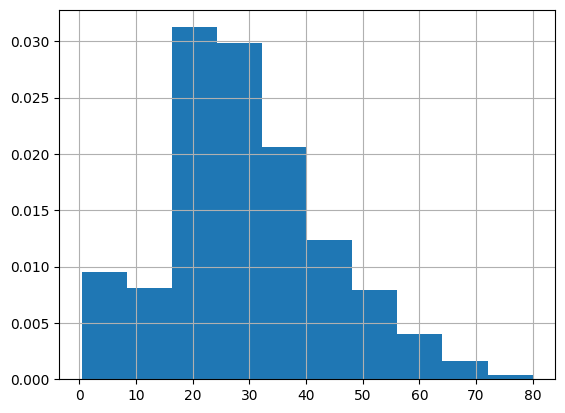

In [62]:
titanic['Age'].hist(density=True)

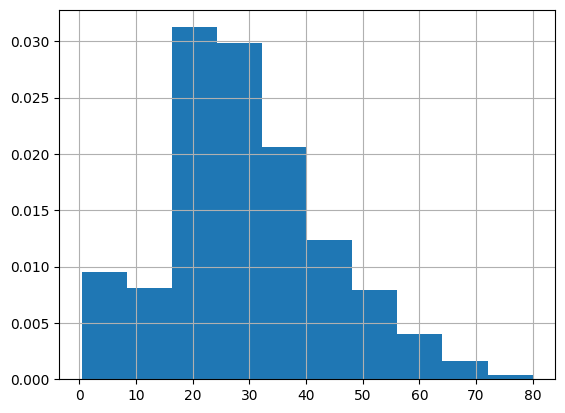

In [63]:
plt.hist(titanic['Age'].dropna().values, density=True)
plt.grid()

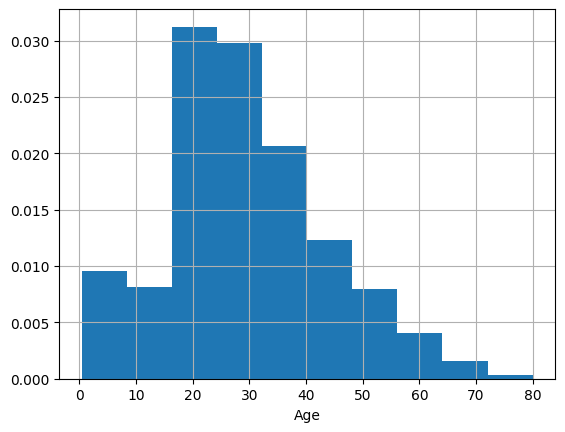

In [64]:
fig, ax = plt.subplots()
titanic['Age'].hist(density=True, ax=ax)
ax.set_xlabel('Age');

In [65]:
titanic['Age_coarse'].value_counts()

Age_coarse
grown-up    592
child       113
senior        7
Name: count, dtype: int64

<Axes: ylabel='count'>

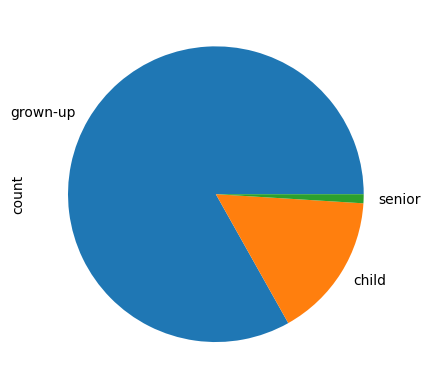

In [66]:
titanic['Age_coarse'].value_counts().plot(kind='pie')

In [67]:
coarse_age_series = titanic['Age_coarse'].cat.add_categories(['unknown'])
coarse_age_series

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643         NaN
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (4, object): ['child' < 'grown-up' < 'senior' < 'unknown']

In [68]:
coarse_age_series.cat.categories

Index(['child', 'grown-up', 'senior', 'unknown'], dtype='object')

In [69]:
coarse_age_series = coarse_age_series.fillna('unknown')
coarse_age_series

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643     unknown
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (4, object): ['child' < 'grown-up' < 'senior' < 'unknown']

In [70]:
coarse_age_series.value_counts()

Age_coarse
grown-up    592
unknown     177
child       113
senior        7
Name: count, dtype: int64

<Axes: ylabel='count'>

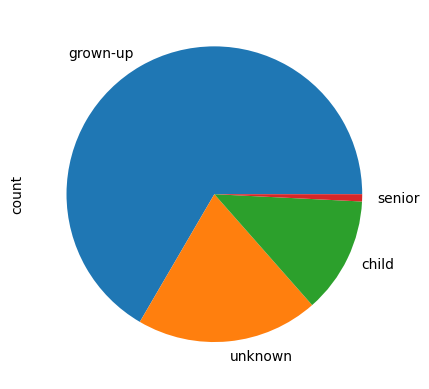

In [71]:
coarse_age_series.value_counts().plot(kind='pie')

<Axes: ylabel='Age_coarse'>

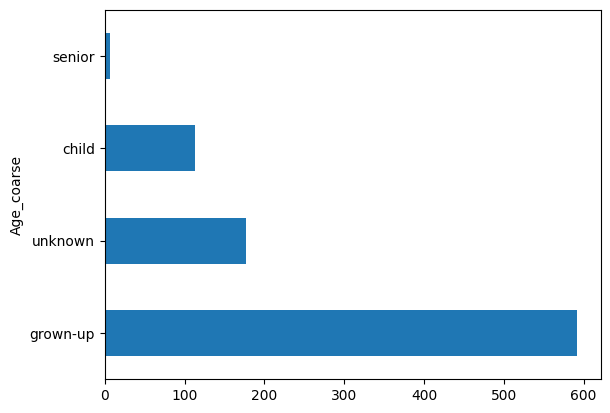

In [72]:
coarse_age_series.value_counts().plot(kind='barh')

The `plot` function also works on DataFrames.

<Axes: xlabel='Age', ylabel='Fare'>

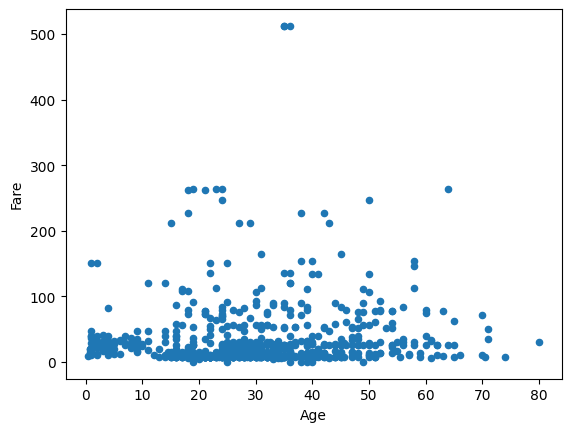

In [73]:
titanic[['Age', 'Fare']].plot(kind='scatter', x='Age', y='Fare')

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html

## Merging DataFrames
Merging is a concept that is often used in relational databases. It allows to combine multiple tables into one by joining the columns with respect to the values in a special key column. There are different options this can be achieved.
![](pictures/merging.png)
The `DataFrame.merge` function offers these functionalities borrowed from SQL (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html#pandas-dataframe-merge).

In [74]:
df1 = pd.DataFrame({'A': [1, 2, 3, 4],
                    'B': [0, np.pi, 2 * np.pi, 3 * np.pi],
                    'C': ['mouse', 'cat', 'dog', 'fish']})
df1

,A,B,C
0,1,0.000000,mouse
1,2,3.141593,cat
2,3,6.283185,dog
3,4,9.424778,fish


In [75]:
df2 = pd.DataFrame({'C': ['mouse', 'horse', 'lizard', 'fish'],
                    'D': [1.0, 1.7, 3.0, 2.1],
                    'E': [1, np.e, np.e ** 2, np.e ** 3]})
df2

,C,D,E
0,mouse,1.0,1.000000
1,horse,1.7,2.718282
2,lizard,3.0,7.389056
3,fish,2.1,20.085537


### Inner Join
The inner join will take the intersection of the keys.

In [76]:
df1.merge(df2, how='inner')

,A,B,C,D,E
0,1,0.000000,mouse,1.0,1.000000
1,4,9.424778,fish,2.1,20.085537


### Left Outer Join
The left outer join will keep all values from the left table (the one on which merge is called) and use `NaN` where the right table is missing the respective rows.

In [77]:
df1.merge(df2, how='left')

,A,B,C,D,E
0,1,0.000000,mouse,1.0,1.000000
1,2,3.141593,cat,NaN,NaN
2,3,6.283185,dog,NaN,NaN
3,4,9.424778,fish,2.1,20.085537


### Right Outer Join
The right outer join works just like the left outer join but instead of using all keys from the left table, it uses all keys from the right one.

In [78]:
df1.merge(df2, how='right')

,A,B,C,D,E
0,1.0,0.000000,mouse,1.0,1.000000
1,NaN,NaN,horse,1.7,2.718282
2,NaN,NaN,lizard,3.0,7.389056
3,4.0,9.424778,fish,2.1,20.085537


### Outer Join
The outer join uses all keys that are present in both the left and the right table. Missing rows in either of the tables are filled with `NaN`.

In [79]:
df1.merge(df2, how='outer')

,A,B,C,D,E
0,1.0,0.000000,mouse,1.0,1.000000
1,2.0,3.141593,cat,NaN,NaN
2,3.0,6.283185,dog,NaN,NaN
3,4.0,9.424778,fish,2.1,20.085537
4,NaN,NaN,horse,1.7,2.718282
5,NaN,NaN,lizard,3.0,7.389056


### Overlapping Column Names

In [80]:
df2 = df2.rename(columns={'D': 'A'})
df2

,C,A,E
0,mouse,1.0,1.000000
1,horse,1.7,2.718282
2,lizard,3.0,7.389056
3,fish,2.1,20.085537


In [92]:
df1

,A,B,C
0,1.0,0.000000,mouse
1,2.0,3.141593,cat
2,3.0,6.283185,dog
3,4.0,9.424778,fish


If it is not implicitly clear on which column the join should occur, we have to tell Pandas which column to use. It can also perform the join on multiple columns but therefore the dtypes of the matched columns inside the two DataFrames must be equal.

In [93]:
df1.merge(df2, how='inner')

,A,B,C,E
0,1.0,0.0,mouse,1.0


We can explicitly tell Pandas on which column the join should occur using the keyword argument `on`. The `suffixes` parameter allows us to control how overlapping column names should be changed in the joined DataFrame.

In [94]:
df1.merge(df2, how='inner', on='C', suffixes=('_from_df1', '_from_df2'))

,A_from_df1,B,C,A_from_df2,E
0,1.0,0.000000,mouse,1.0,1.000000
1,4.0,9.424778,fish,2.1,20.085537


In [84]:
df1['A'] = df1['A'].astype(float)
df1.merge(df2, how='inner', on=['A', 'C'])

,A,B,C,E
0,1.0,0.0,mouse,1.0
